# <font color='blue'>Abundant Power

Table of Content:

1. 'Unlimited' Source

2. EDA

3. Features

4. Predict electricity output

5. Identifying maintenance need


# 1. 'Unlimited' Source

# <font color='orange'>Solar power is an important form of renewable energy. Photovaltaic electricity of two power plants are monitored along with their ambient enviorment information. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import optuna # optuna, hypter paramater optimisation, basiclally will test lots of different variations of XGB settings
import shap # SHAP (SHapley Additive exPlanations) explains the output of the machine learning model.
import pickle

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from pathlib import Path

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score



# Importing Data

In [3]:
plant1_generation = pd.read_csv('../input/solar-power-generation-data/Plant_1_Generation_Data.csv')
plant1_weather = pd.read_csv('../input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv')
plant2_generation = pd.read_csv('../input/solar-power-generation-data/Plant_2_Generation_Data.csv')
plant2_weather = pd.read_csv('../input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv')


# 2. EDA

In [4]:
plant1_generation.describe()
plant1_weather.describe()

,PLANT_ID,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,3182.0,3182.000000,3182.000000,3182.000000
mean,4135001.0,25.531606,31.091015,0.228313
std,0.0,3.354856,12.261222,0.300836
min,4135001.0,20.398505,18.140415,0.000000
25%,4135001.0,22.705182,21.090553,0.000000
50%,4135001.0,24.613814,24.618060,0.024653
75%,4135001.0,27.920532,41.307840,0.449588
max,4135001.0,35.252486,65.545714,1.221652


In [5]:
plant1_weather.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [6]:
plant1_generation.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [7]:
plant1_generation.info()
plant2_generation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67698 entries, 0 to 67697
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    67698 non-null  object 
 1   PLANT_ID     67698 non-null  int64  
 2   SOURCE_KEY   67698 non-null  object 
 3   DC_POWER     67698 non-null  float64
 4   AC_POWER     67698 non-null  float64
 5   DAILY_YIELD  67698 non-null  float64
 6   TOT

In [8]:
plant1_weather.info()
plant2_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   PLANT_ID             3182 non-null   int64  
 2   SOURCE_KEY           3182 non-null   object 
 3   AMBIENT_TEMPERATURE  3182 non-null   float64
 4   MODULE_TEMPERATURE   3182 non-null   float64
 5   IRRADIATION          3182 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 149.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3259 non-null   object 
 1   PLANT_ID             3259 non-null   int64  
 2   SOURCE_KEY           3259 non-null   object 
 3   AMBIENT_TEMPERATURE  3259 non-null   float64
 4   MODULE_TEMPERATURE 

In [9]:
plant1_generation.columns= ['dt_time', 'plant_id', 'source_key', 'dc_power', 'ac_power', 'daily_yield', 'total_yield']
plant1_weather.columns = ['dt_time', 'plant_id', 'source_key', 'amb_temp', 'mod_temp', 'irrad']
plant2_generation.columns = ['dt_time', 'plant_id', 'source_key', 'dc_power', 'ac_power', 'daily_yield', 'total_yield']
plant2_weather.columns = ['dt_time', 'plant_id', 'source_key', 'amb_temp', 'mod_temp', 'irrad']

In [10]:
dataframes=[plant1_generation,plant2_generation,
            plant1_weather,plant2_weather]

for i in dataframes:
    print('start date ',i.dt_time.min(), 'end date ',i.dt_time.max())

start date  01-06-2020 00:00 end date  31-05-2020 23:45
start date  2020-05-15 00:00:00 end date  2020-06-17 23:45:00
start date  2020-05-15 00:00:00 end date  2020-06-17 23:45:00
start date  2020-05-15 00:00:00 end date  2020-06-17 23:45:00


In [11]:
# fixing the date time

plant1_generation['dt_time']= pd.to_datetime(plant1_generation['dt_time'],format='%d-%m-%Y %H:%M')
plant1_weather['dt_time']= pd.to_datetime(plant1_weather['dt_time'],format='%Y-%m-%d %H:%M:%S')
plant2_generation['dt_time']= pd.to_datetime(plant2_generation['dt_time'],format='%Y-%m-%d %H:%M')
plant2_weather['dt_time']= pd.to_datetime(plant2_weather['dt_time'],format='%Y-%m-%d %H:%M:%S')

In [12]:
print('Counts of source keys in plant1_generation')
print (plant1_generation.source_key.value_counts())
print('\n')
print('Counts of source keys in plant2_generation')
print (plant2_generation.source_key.value_counts())
print('\n')
print('Counts of source keys in plant1_weather')
print (plant1_weather.source_key.value_counts())
print('\n')
print('Counts of source keys in plant2_weather')
print (plant2_weather.source_key.value_counts())


Counts of source keys in plant1_generation
bvBOhCH3iADSZry    3155
1BY6WEcLGh8j5v7    3154
7JYdWkrLSPkdwr4    3133
VHMLBKoKgIrUVDU    3133
ZnxXDlPa8U1GXgE    3130
ih0vzX44oOqAx2f    3130
z9Y9gH1T5YWrNuG    3126
wCURE6d3bPkepu2    3126
uHbuxQJl8lW7ozc    3125
pkci93gMrogZuBj    3125
iCRJl6heRkivqQ3    3125
rGa61gmuvPhdLxV    3124
sjndEbLyjtCKgGv    3124
McdE0feGgRqW7Ca    3124
zVJPv84UY57bAof    3124
ZoEaEvLYb1n2sOq    3123
1IF53ai7Xc0U56Y    3119
adLQvlD726eNBSB    3119
zBIq5rxdHJRwDNY    3119
WRmjgnKYAwPKWDb    3118
3PZuoBAID5Wc2HD    3118
YxYtjZvoooNbGkE    3104
Name: source_key, dtype: int64


Counts of source keys in plant2_generation
xoJJ8DcxJEcupym    3259
WcxssY2VbP4hApt    3259
9kRcWv60rDACzjR    3259
vOuJvMaM2sgwLmb    3259
rrq4fwE8jgrTyWY    3259
LYwnQax7tkwH5Cb    3259
LlT2YUhhzqhg5Sw    3259
q49J1IKaHRwDQnt    3259
oZZkBaNadn6DNKz    3259
PeE6FRyGXUgsRhN    3259
81aHJ1q11NBPMrL    3259
V94E5Ben1TlhnDV    3259
oZ35aAeoifZaQzV    3195
4UPUqMRk7TRMgml    3195
Qf4GUc1pJu5T6c6  

# Preparing to merge generation data with weather data

In [13]:
for i in dataframes:
    i["source_key"] =  i["source_key"].astype('category')
    i["simp_source"] = i["source_key"].cat.codes
    
plant1_generation['plant_id_new'] = 1
plant1_weather['plant_id_new'] = 1
plant2_generation['plant_id_new'] = 2
plant2_weather['plant_id_new'] = 2

for i in dataframes:
    i['plant_id_new'] = i['plant_id_new'].astype('string')
    i['simp_source'] = i['simp_source'].astype('string')
    i['plant_array'] = i['plant_id_new'] + '/' + i['simp_source']
    i['plant_id_new'] = i['plant_id_new'].astype('category')
    i['simp_source'] = i['simp_source'].astype('category')


In [14]:
plant1_generation.info()
plant2_generation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   dt_time       68778 non-null  datetime64[ns]
 1   plant_id      68778 non-null  int64         
 2   source_key    68778 non-null  category      
 3   dc_power      68778 non-null  float64       
 4   ac_power      68778 non-null  float64       
 5   daily_yield   68778 non-null  float64       
 6   total_yield   68778 non-null  float64       
 7   simp_source   68778 non-null  category      
 8   plant_id_new  68778 non-null  category      
 9   plant_array   68778 non-null  string        
dtypes: category(3), datetime64[ns](1), float64(4), int64(1), string(1)
memory usage: 3.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67698 entries, 0 to 67697
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  ----

In [15]:
plant1_weather.info()
plant2_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   dt_time       3182 non-null   datetime64[ns]
 1   plant_id      3182 non-null   int64         
 2   source_key    3182 non-null   category      
 3   amb_temp      3182 non-null   float64       
 4   mod_temp      3182 non-null   float64       
 5   irrad         3182 non-null   float64       
 6   simp_source   3182 non-null   category      
 7   plant_id_new  3182 non-null   category      
 8   plant_array   3182 non-null   string        
dtypes: category(3), datetime64[ns](1), float64(3), int64(1), string(1)
memory usage: 158.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   dt_time       3259 non-null   datetime

In [16]:
print('dt_time.count in plant1_generation')
print (plant1_generation.dt_time.count())
print('\n')
print('dt_time.count in plant2_generation')
print (plant2_generation.dt_time.count())
print('\n')
print('dt_time.count in plant1_weather')
print (plant1_weather.dt_time.count())
print('\n')
print('dt_time.count in plant2_weather')
print (plant2_weather.dt_time.count())


dt_time.count in plant1_generation
68778


dt_time.count in plant2_generation
67698


dt_time.count in plant1_weather
3182


dt_time.count in plant2_weather
3259


# 3. Features

# Creating Dataframes with both generation and weather data

In [17]:
plant1 = pd.merge(plant1_generation, plant1_weather, how='inner', on = 'dt_time')
plant2 = pd.merge(plant2_generation, plant2_weather, how='inner', on = 'dt_time')

df = pd.concat([plant1,plant2], axis = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136472 entries, 0 to 67697
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   dt_time         136472 non-null  datetime64[ns]
 1   plant_id_x      136472 non-null  int64         
 2   source_key_x    136472 non-null  object        
 3   dc_power        136472 non-null  float64       
 4   ac_power        136472 non-null  float64       
 5   daily_yield     136472 non-null  float64       
 6   total_yield     136472 non-null  float64       
 7   simp_source_x   136472 non-null  category      
 8   plant_id_new_x  136472 non-null  object        
 9   plant_array_x   136472 non-null  string        
 10  plant_id_y      136472 non-null  int64         
 11  source_key_y    136472 non-null  object        
 12  amb_temp        136472 non-null  float64       
 13  mod_temp        136472 non-null  float64       
 14  irrad           136472 non-null  floa

# removing extra columns

In [18]:
df = df[['dt_time',
        'plant_array_x',
        'dc_power',
        'ac_power',
       'daily_yield',
        'total_yield',
        'amb_temp',
        'mod_temp',
       'irrad',
        'simp_source_x',
        'plant_id_new_x']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136472 entries, 0 to 67697
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   dt_time         136472 non-null  datetime64[ns]
 1   plant_array_x   136472 non-null  string        
 2   dc_power        136472 non-null  float64       
 3   ac_power        136472 non-null  float64       
 4   daily_yield     136472 non-null  float64       
 5   total_yield     136472 non-null  float64       
 6   amb_temp        136472 non-null  float64       
 7   mod_temp        136472 non-null  float64       
 8   irrad           136472 non-null  float64       
 9   simp_source_x   136472 non-null  category      
 10  plant_id_new_x  136472 non-null  object        
dtypes: category(1), datetime64[ns](1), float64(7), object(1), string(1)
memory usage: 11.6+ MB


In [19]:
df.head()

,dt_time,plant_array_x,dc_power,ac_power,daily_yield,total_yield,amb_temp,mod_temp,irrad,simp_source_x,plant_id_new_x
0,2020-05-15,1/0,0.0,0.0,0.0,6259559.0,25.184316,22.857507,0.0,0,1
1,2020-05-15,1/1,0.0,0.0,0.0,6183645.0,25.184316,22.857507,0.0,1,1
2,2020-05-15,1/2,0.0,0.0,0.0,6987759.0,25.184316,22.857507,0.0,2,1
3,2020-05-15,1/3,0.0,0.0,0.0,7602960.0,25.184316,22.857507,0.0,3,1
4,2020-05-15,1/4,0.0,0.0,0.0,7158964.0,25.184316,22.857507,0.0,4,1


# Data with zero power generation

In [20]:
full = df.daily_yield.count() 
zeros = df.loc[df['daily_yield']==0].daily_yield.count()

print('num rows full and zeros:', full,'and', zeros)
print ('num rows after removed zeros: ', full - zeros)
print ('percentage zeros: ', zeros / full)

num rows full and zeros: 136472 and 30265
num rows after removed zeros:  106207
percentage zeros:  0.22176710240928543


In [21]:
df = df.loc[df['daily_yield']!=0].copy()
df.reset_index(inplace = True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106207 entries, 0 to 106206
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   index           106207 non-null  int64         
 1   dt_time         106207 non-null  datetime64[ns]
 2   plant_array_x   106207 non-null  string        
 3   dc_power        106207 non-null  float64       
 4   ac_power        106207 non-null  float64       
 5   daily_yield     106207 non-null  float64       
 6   total_yield     106207 non-null  float64       
 7   amb_temp        106207 non-null  float64       
 8   mod_temp        106207 non-null  float64       
 9   irrad           106207 non-null  float64       
 10  simp_source_x   106207 non-null  category      
 11  plant_id_new_x  106207 non-null  object        
dtypes: category(1), datetime64[ns](1), float64(7), int64(1), object(1), string(1)
memory usage: 9.0+ MB


# Comparing daily yield

<AxesSubplot:title={'center':'Plant 1'}, xlabel='dt_time'>

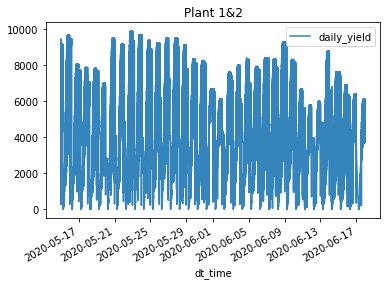

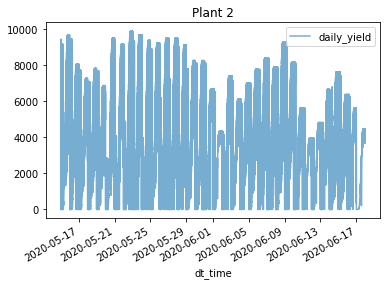

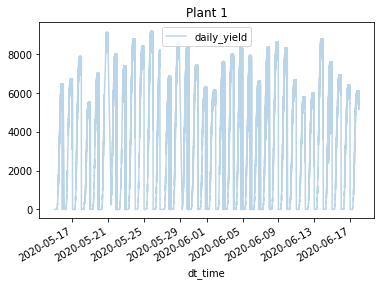

In [23]:
df.plot(x = 'dt_time', y = 'daily_yield',title='Plant 1&2', alpha=0.9)
plant2_generation.plot(x = 'dt_time', y = 'daily_yield', title='Plant 2', alpha=0.6)
plant1_generation.plot(x = 'dt_time', y = 'daily_yield',title='Plant 1', alpha=0.3)

# Add a column for date


In [24]:
df['date'] = pd.to_datetime(df['dt_time']).dt.date

# Define a  function for scatter plot

In [25]:
def plot_scatter(df, feat_1, feat_2):
    plt.figure(figsize=(9,9))
    sns.scatterplot(data=df, x=feat_1, y = feat_2)
    #Title = f'{feat_1, feat_2}'
    #plt.title(Title, fontsize=15)
    plt.show()

# Visualizations

df1 = df.loc[df['ac_power'] > 0]

plot_scatter(df1, 'amb_temp', 'ac_power')
plot_scatter(df1, 'amb_temp', 'dc_power')

plot_scatter(df1, 'mod_temp', 'ac_power')
plot_scatter(df1, 'mod_temp', 'dc_power')

plot_scatter(df1, 'irrad', 'ac_power')
plot_scatter(df1, 'irrad', 'dc_power')

# Correlation map

def fancy_plot(df, method = 'pearson', annot = True, **kwargs):
    sns.clustermap(df.corr(method), vmin = -1.0, vmax = 1.0, cmap = 'icefire', method = 'complete', annot = annot, **kwargs)

fancy_plot(df)

In [26]:
df.simp_source_x = df.simp_source_x.astype('category')
df.plant_id_new_x = df.plant_id_new_x.astype('category')

In [27]:
df.corr()

,index,dc_power,ac_power,daily_yield,total_yield,amb_temp,mod_temp,irrad
index,1.000000,-0.048244,-0.098200,-0.057981,-0.014972,-0.342835,-0.207349,-0.124240
dc_power,-0.048244,1.000000,0.722636,-0.140487,-0.291176,0.194727,0.613564,0.636043
ac_power,-0.098200,0.722636,1.000000,-0.234858,-0.063856,0.505482,0.839418,0.876503
daily_yield,-0.057981,-0.140487,-0.234858,1.000000,-0.070709,0.162830,-0.171878,-0.312730
total_yield,-0.014972,-0.291176,-0.063856,-0.070709,1.000000,0.169890,0.011002,-0.014680
amb_temp,-0.342835,0.194727,0.505482,0.162830,0.169890,1.000000,0.773561,0.592976
mod_temp,-0.207349,0.613564,0.839418,-0.171878,0.011002,0.773561,1.000000,0.944982
irrad,-0.124240,0.636043,0.876503,-0.312730,-0.014680,0.592976,0.944982,1.000000


# correlation with dc_power vs ac_power

In [28]:
df1 = df.loc[df['dc_power']>0].copy()
df1 = df.loc[df['ac_power']>0].copy()
df1 = df1[['ac_power', 'dc_power', 'amb_temp', 'mod_temp', 'irrad', 'simp_source_x', 'plant_id_new_x']].copy()
print(df1.corr())

          ac_power  dc_power  amb_temp  mod_temp     irrad
ac_power  1.000000  0.625683  0.464106  0.890201  0.963654
dc_power  0.625683  1.000000  0.048213  0.566954  0.605361
amb_temp  0.464106  0.048213  1.000000  0.711677  0.472722
mod_temp  0.890201  0.566954  0.711677  1.000000  0.916068
irrad     0.963654  0.605361  0.472722  0.916068  1.000000


# 4. Predicting power output

# Define a function to plot predicted vs actual

In [29]:
def plot_pred_actual_ac(y_pred, y_test, scale):
    predicted_value = y_pred
    true_value = y_test
    plt.figure(figsize=(10,5))
    plt.scatter(true_value, predicted_value, c='yellow')
    p1 = max(max(predicted_value), max(true_value))
    p2 = min(min(predicted_value), min(true_value))
    plt.plot([p1, p2],[p1, p2]) #, 'b-')
    plt.title = 'Predicting AC output'
    plt.xlabel('True AC Output', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    
def plot_pred_actual_dc(y_pred, y_test, scale):
    predicted_value = y_pred
    true_value = y_test
    plt.figure(figsize=(10,5))
    plt.scatter(true_value, predicted_value, c='green')
    p1 = max(max(predicted_value), max(true_value))
    p2 = min(min(predicted_value), min(true_value))
    plt.plot([p1, p2],[p1, p2]) #, 'b-')
    plt.title = 'Predicting DC output'
    plt.xlabel('True DC Output', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')

# linear regression to predict DC and AC output

In [30]:
from sklearn.metrics import mean_squared_error,r2_score
def lin_reg_ac(X,y,test_size,scale):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=14)
    reg = LinearRegression().fit(X, y)
    pred = reg.predict(X_test)
    print ('AC rmse: ',mean_squared_error(y_test, pred, squared = False))
    print('AC r2: ', r2_score(y_test, pred))
    plot_pred_actual_ac(y_test, pred, scale)
    return pred

from sklearn.metrics import mean_squared_error,r2_score
def lin_reg_dc(X,y,test_size,scale):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=14)
    reg = LinearRegression().fit(X, y)
    pred = reg.predict(X_test)
    print ('DC rmse: ',mean_squared_error(y_test, pred, squared = False))
    print('DC r2: ', r2_score(y_test, pred))
    plot_pred_actual_dc(y_test, pred, scale)
    return pred

AC rmse:  98.99333740188432
AC r2:  0.9296523491439032
DC rmse:  1679.1553178451447
DC r2:  0.8121974639047609


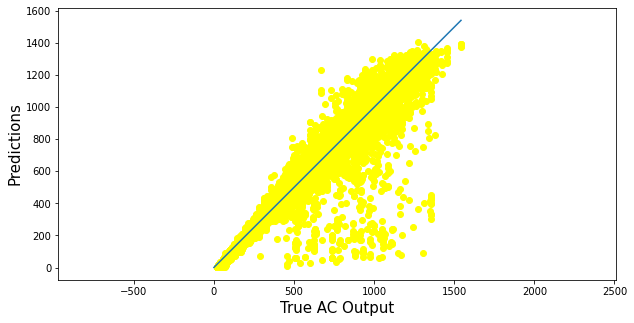

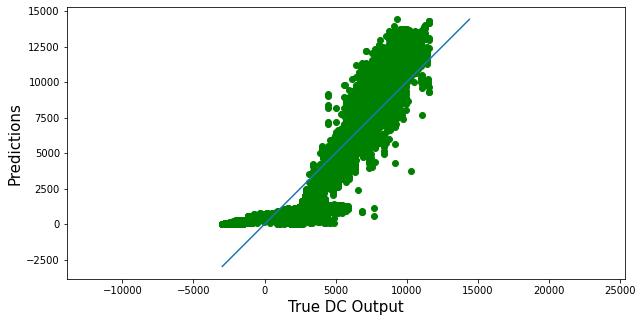

In [31]:
X = df1[['amb_temp', 'mod_temp', 'irrad',
       'simp_source_x', 'plant_id_new_x']] #.copy().to_numpy()
y_ac = df1['ac_power']
y_dc = df1['dc_power']
pred_ac = lin_reg_ac(X,y_ac,10,'linear')
pred_dc = lin_reg_dc(X,y_dc,10,'linear')

# less features

AC rmse:  99.21776719958115
AC r2:  0.9293330144040992
DC rmse:  2430.890451745783
DC r2:  0.606404168856709


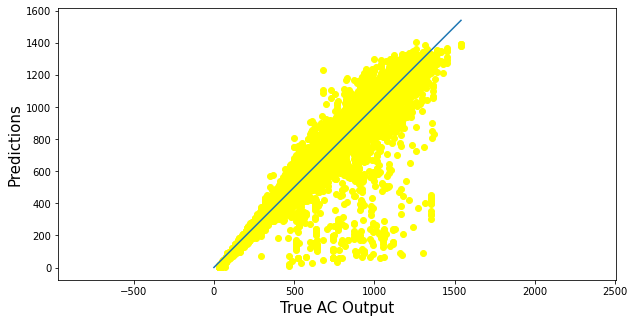

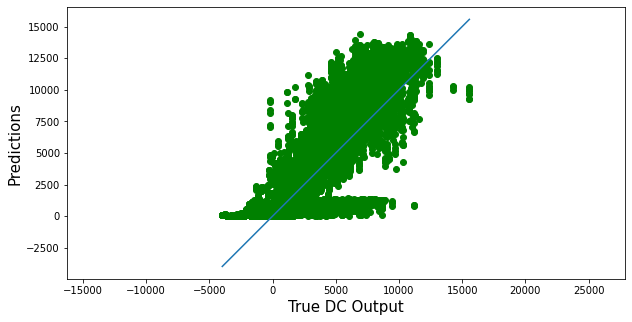

In [32]:
X = df1[['amb_temp', 'mod_temp', 'irrad']] 
y_ac = df1['ac_power']
y_dc = df1['dc_power']
pred_ac = lin_reg_ac(X,y_ac,10,'linear')
pred_dc = lin_reg_dc(X,y_dc,10,'linear')

# min max scaling

AC rmse:  0.07018331892682081
AC r2:  0.9296523491439032


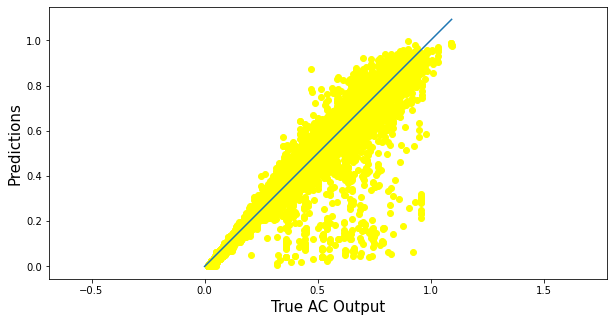

In [33]:
from sklearn.preprocessing import MinMaxScaler

X = df1[['amb_temp', 'mod_temp', 'irrad',
       'simp_source_x', 'plant_id_new_x', 'ac_power']].copy().to_numpy()

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

y_ac = X[:,5]
X = X[:,0:5]


pred_ac2 = lin_reg_ac(X,y_ac,20,'linear')

## XGBoost


default parameters

In [34]:
# Default paramaters for XHBoost, we will use Optuna to optimise these parameters later
# remember when putting a dictionary in a function you need to proceed it with **

xgb_params = dict(
    max_depth=3,                           # maximum depth of each tree - try 2 to 10
    learning_rate=000.1,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=200,                     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=1,                    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=1,   # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=1,          # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0,        # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=1,         # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,                   # set > 1 for boosted random forests
)

Function to test the model with parameters

In [35]:
# function to do some boosting

def xgb_score(X, y, model=XGBRegressor(**xgb_params)):
    
    #changing the categorical labels into numbers for the model
    for name in X.select_dtypes(['category']):
        X[name] = X[name].cat.codes
        
    #Changing y to a log, we will have to change it back before we submit exp
    y_log = np.log(y)
    
    score = cross_val_score(model,X, y_log, cv=5, scoring = 'neg_mean_squared_error')
    score = -1 *score.mean()
    score = np.sqrt(score)
    return(score)
    print(score)

Getting performance score benchmark

In [36]:
# getting the score!

y_ac = df1['ac_power'].copy()
y_dc = df1['dc_power'].copy()
X = df1[['amb_temp', 'mod_temp', 'irrad', 'simp_source_x', 'plant_id_new_x']].copy()

xgb_score(X,y_dc, model=XGBRegressor(**xgb_params))

0.22606488134694144

Getting the model to make predictions

In [37]:
y_ac = df1['ac_power'].copy()
y_dc = df1['dc_power'].copy()
X = df1[['amb_temp', 'mod_temp', 'irrad', 'simp_source_x', 'plant_id_new_x']].copy()
for name in X.select_dtypes(['category']):
        X[name] = X[name].cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y_ac, test_size=0.5, random_state=8)

xgb = XGBRegressor(**xgb_params)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Plotting model predictions

rmse:  81.19029930708527
r2:  0.9526285138764967


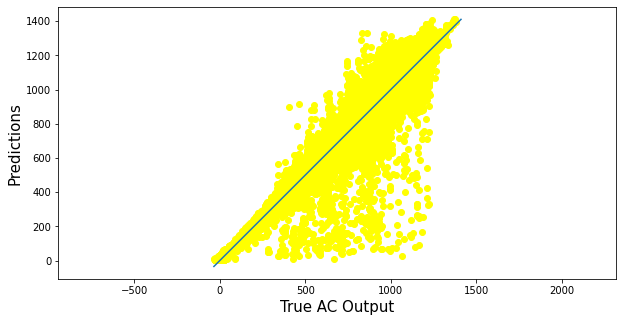

In [38]:
y_ac_pred = xgb.predict(X_test)

print ('rmse: ',mean_squared_error(y_test, y_ac_pred, squared = False))
print('r2: ', r2_score(y_test, y_ac_pred))

plot_pred_actual_ac(y_test, y_ac_pred, 'linear')

## Tuning XGb regressor

In [39]:
# # trial parameters telling optuna where to test, this will take a long time

# y_ac = df1['ac_power'].copy()
# y_dc = df1['dc_power'].copy()
# X = df1[['amb_temp', 'mod_temp', 'irrad', 'simp_source_x']].copy()

# def objective(trial):
#     xgb_params = dict(
#         max_depth=trial.suggest_int("max_depth", 2, 10),
#         learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
#         n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
#         min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
#         colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
#         subsample=trial.suggest_float("subsample", 0.2, 1.0),
#         reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
#         reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
#     )
#     xgb = XGBRegressor(**xgb_params)
    
#     return score_please(X_train, y_train, xgb)

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=50)
# xgb_params = study.best_params

Trial 49 finished with value: 0.16540890969688846 and parameters: {'max_depth': 8, 'learning_rate': 0.007370619279795246, 'n_estimators': 2222, 'min_child_weight': 7, 'colsample_bytree': 0.894850599575649, 'subsample': 0.8510498418045354, 'reg_alpha': 0.10371479505123118, 'reg_lambda': 0.10371479505123118}. Best is trial 48 with value: 0.1650462969089919.

In [40]:
# parameters from the best performing test

xgb_params = dict(
    max_depth=8,                        
    learning_rate=0.007370619279795246,
    n_estimators=2222,
    min_child_weight=7,
    colsample_bytree=0.894850599575649,
    subsample=0.8510498418045354,
    reg_alpha=0.10371479505123118,
    reg_lambda=0.10371479505123118,
    num_parallel_tree=1,
)

In [41]:
# y_ac = df1['ac_power'].copy()
# y_dc = df1['dc_power'].copy()
# X = df1[['amb_temp', 'mod_temp', 'irrad', 'simp_source_x', 'plant_id_new_x']].copy()

# score_please(X, y_ac, model=XGBRegressor(**xgb_params))

Making predictions with the new parameters and plotting the results

In [42]:
y_ac = df1['ac_power'].copy()
y_dc = df1['dc_power'].copy()
X = df1[['amb_temp', 'mod_temp', 'irrad', 'simp_source_x', 'plant_id_new_x']].copy()
for name in X.select_dtypes(['category']):
        X[name] = X[name].cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y_ac, test_size=0.5, random_state=8)

xgb = XGBRegressor(**xgb_params)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.894850599575649,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.007370619279795246,
             max_delta_step=0, max_depth=8, min_child_weight=7, missing=nan,
             monotone_constraints='()', n_estimators=2222, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.10371479505123118, reg_lambda=0.10371479505123118,
             scale_pos_weight=1, subsample=0.8510498418045354,
             tree_method='exact', validate_parameters=1, verbosity=None)

rmse:  68.95151285704964
r2:  0.9658338279540168


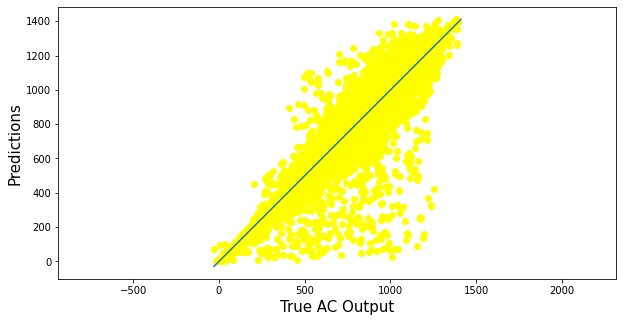

In [43]:
y_ac_pred = xgb.predict(X_test)

print ('rmse: ',mean_squared_error(y_test, y_ac_pred, squared = False))
print('r2: ', r2_score(y_test, y_ac_pred))

plot_pred_actual_ac(y_test, y_ac_pred, 'linear')

# 5. Performance and Irradiation by Panel Arrays
Can we identify broken pannels, if any?
For arrays that are not working, their daily_yield would be lower than the average of the other arrays.
plan:

1. did any arrays produce zero output for any individual day?
3. how does each array performa compared to the plant average


In [44]:
# sticking the two dataframes together and starting from scratch

plant1 = pd.merge(plant1_generation, plant1_weather, how='inner', on = 'dt_time')
plant2 = pd.merge(plant2_generation, plant2_weather, how='inner', on = 'dt_time')
df = pd.concat([plant1,plant2])
# re organising columns and removing extra columns
df = df[['dt_time',
        'plant_array_x',
        'dc_power',
        'ac_power',
       'daily_yield',
        'total_yield',
        'amb_temp',
        'mod_temp',
       'irrad',
        'simp_source_x',
        'plant_id_new_x']]
df['date'] = pd.to_datetime(df['dt_time']).dt.date
df.columns = ['dt', 'plant_array', 'dc_power', 'ac_power', 'daily_yield',
       'total_yield', 'amb_temp', 'mod_temp', 'irrad', 'array',
       'plant', 'date']

## Solar panels with zero output

In [45]:
avg_period_power = df.pivot_table(index = ['plant', 'array'], columns = 'date', values = 'daily_yield', aggfunc = max)
avg_period_power.reset_index(inplace = True)



In [46]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
avg_period_power['average_daily_power_yield'] = avg_period_power.iloc[:,-34:].mean(axis = 1).copy()

avg_period_power

date,plant,array,2020-05-15,2020-05-16,2020-05-17,2020-05-18,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,2020-06-08,2020-06-09,2020-06-10,2020-06-11,2020-06-12,2020-06-13,2020-06-14,2020-06-15,2020-06-16,2020-06-17,average_daily_power_yield
0,1,0,5754.0,6292.000000,7045.0,4998.0,6449.000,8249.0,7243.000000,6848.0,7966.0,7537.000000,8268.0,7456.428571,6164.000000,7977.0,7564.000000,6754.000000,5803.0,5508.000000,7029.000000,7341.0,7571.000000,7162.000000,5940.0,5268.0,7864.0,7456.000000,5911.0,5257.000000,5441.0,7984.000000,4012.0,6275.000000,5848.0,5521.0,6639.865546
1,1,1,6357.0,6592.000000,7759.0,5453.0,6568.750,8997.0,7816.500000,7287.0,8673.0,8273.000000,9048.0,8109.500000,6824.000000,8496.0,8253.000000,7332.000000,5889.0,6012.000000,7338.000000,7875.0,8196.000000,7701.666667,6542.0,8239.0,8495.0,8189.000000,6598.0,5704.000000,5903.0,8654.000000,7487.0,6846.000000,6318.0,6034.0,7348.806373
2,1,10,6383.0,6705.000000,7867.0,5506.0,6639.875,9102.0,7954.750000,7378.0,8783.0,8397.000000,9163.0,8222.000000,6857.000000,8636.0,8343.000000,7419.000000,5933.0,6127.000000,7443.000000,7991.0,8314.000000,7847.000000,6603.0,8353.0,8620.0,8273.000000,6667.0,5790.000000,5988.0,8774.000000,7590.0,6916.000000,6396.0,6110.0,7443.841912
3,1,11,5707.0,6138.000000,6928.0,4962.0,6369.000,8131.0,7110.000000,6760.0,7864.0,7440.000000,8124.0,7364.000000,6133.000000,7752.0,7438.000000,6658.000000,5586.0,5378.000000,6842.000000,7237.0,7462.000000,7065.000000,5873.0,5169.0,7693.0,7361.000000,5863.0,5197.000000,5372.0,7863.000000,3958.0,6192.000000,5757.0,5460.0,6535.470588
4,1,12,6418.0,6438.000000,7519.0,5400.0,6951.000,8887.0,7837.000000,7151.0,8627.0,8041.000000,8869.0,7866.000000,6694.000000,8345.0,8216.000000,7345.000000,5969.0,5781.000000,7465.000000,7883.0,8303.714286,7803.000000,6430.0,8277.0,8444.0,8265.000000,6559.0,5692.000000,5888.0,8496.000000,7369.0,6777.000000,6305.0,5957.0,7301.991597
5,1,13,6176.0,6450.000000,7391.0,5286.0,6790.000,8664.0,7598.571429,7000.0,8395.0,7556.000000,8085.0,7712.000000,6564.000000,8315.0,7951.000000,7146.000000,5965.0,5751.000000,7326.333333,7699.0,8009.000000,7456.500000,6197.0,8019.0,8217.0,7846.000000,6277.0,5521.000000,5710.0,8255.000000,7165.0,6564.000000,6124.0,5758.0,7086.453081
6,1,14,6375.0,6173.000000,7397.0,5364.0,6938.000,8849.0,7778.000000,7224.0,8475.0,8032.000000,8812.0,7774.000000,6690.000000,8273.0,8276.666667,7341.000000,5915.0,5509.000000,7350.000000,7786.0,8254.285714,7796.000000,6431.0,8214.0,8344.0,8240.000000,6578.0,5662.000000,5851.0,8354.000000,7261.0,6795.000000,6261.0,5952.0,7244.851541
7,1,15,6373.0,6233.000000,7438.0,5365.0,6910.000,8821.0,7766.000000,6742.0,8152.0,8002.000000,8807.0,7767.000000,6678.000000,8266.0,8258.500000,7364.000000,5894.0,5637.000000,7361.000000,7807.0,8212.000000,7741.000000,6410.5,8172.0,8291.0,8240.000000,6565.0,5663.000000,5849.0,8389.000000,7302.0,6732.000000,6243.0,5950.0,7217.676471
8,1,16,6350.0,6431.000000,7441.0,5351.0,6879.000,8777.0,7825.000000,7076.0,8487.0,7902.000000,8760.0,7778.000000,6674.000000,8338.0,8125.500000,7226.000000,5987.0,5766.000000,7439.000000,7846.0,8224.857143,7759.000000,6379.0,6898.0,8371.0,8170.000000,6505.0,5654.000000,5847.0,8403.000000,7307.0,6728.000000,6255.0,5887.0,7201.363445
9,1,17,6387.0,6271.000000,7454.0,5408.0,6997.000,8913.0,7865.000000,7277.0,8493.0,8106.000000,8844.0,7842.000000,6717.666667,8374.0,8299.000000,7340.000000,6081.0,5589.000000,7463.000000,7850.0,8279.714286,7838.000000,6482.0,8294.0,8405.0,8309.000000,6645.0,5698.000000,5888.0,8437.000000,7306.0,6906.000000,6292.0,5967.0,7303.452381


above we can see that 2/4, 2/8, 2/14, 2/20 all generated no power from 21 - 28 May

Average perofmance of plant 1 arrays and plant 2 arrays

In [47]:
# checking the average of all the arrays
avg_period_power.average_daily_power_yield.mean()


6743.885976708424

Lets seperate the plants, work out the mean daily yield per plant and check how each array performs against the mean

In [48]:
def performance_to_mean (df ,plant, Title):
    
    array_monthly_average = df.loc[df['plant']==plant].copy()
    array_monthly_average = array_monthly_average[['plant','array', 'average_daily_power_yield']]
    avg = array_monthly_average['average_daily_power_yield'].mean()
    array_monthly_average['performance_%'] = ((array_monthly_average['average_daily_power_yield'] - avg) / avg) *100
    array_monthly_average.sort_values(by = 'performance_%', inplace=True)
    
    array_monthly_average.plot(x = 'array', y = 'performance_%', kind = 'barh', figsize = (10,10), title = Title, ylabel = '%' )  

#  Array performance as compared to plant average

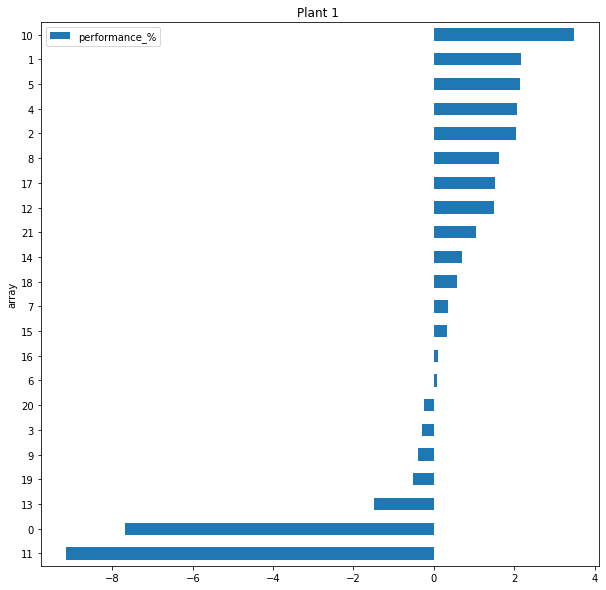

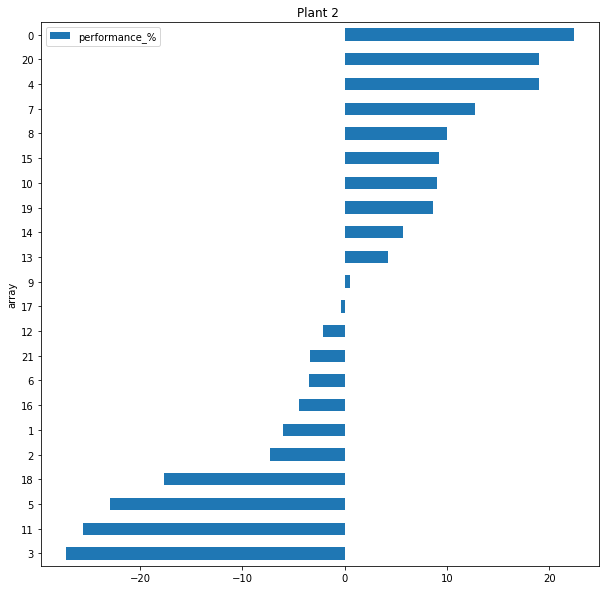

In [49]:
performance_to_mean(avg_period_power, '1', 'Plant 1 ')
performance_to_mean(avg_period_power, '2', 'Plant 2 ')

In [50]:
df.head()
df['irrad_yield'] = df['daily_yield'] / df['irrad']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df['irrad_yield'] = df['irrad_yield'].fillna(0)
df.irrad_yield.value_counts()

irrad_df = df.pivot_table(index = ['plant', 'array'], values = ['irrad_yield'], aggfunc = np.mean)
irrad_df.reset_index(inplace = True)
irrad_df = pd.DataFrame(data = irrad_df)


function to make performance chart

In [51]:
def performance_to_mean_irrad (df,col,plant, Title):
    df[col] = df[col].round(2).copy()
    df.sort_values(col, inplace = True)
    df1 = df.loc[df['plant'] == plant].copy()
    avg = df1[col].mean()
    df1['performance_%'] = ((df1[col] - avg) / avg) *100
    return df1.plot(x = 'array', y = 'performance_%', kind = 'barh', figsize = (10,10), title = Title)
    
    
    

#  Array irradiation as compared to Plant average

<AxesSubplot:title={'center':'Plant 1 Irradiance to AC Power Production Compared to Plant Average'}, ylabel='array'>

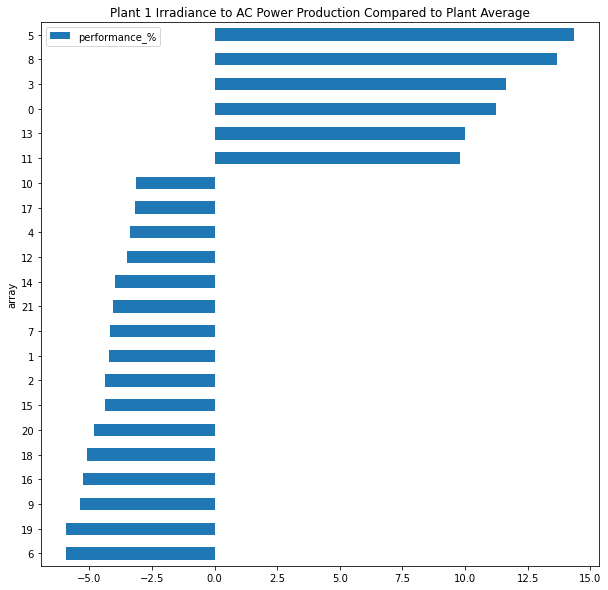

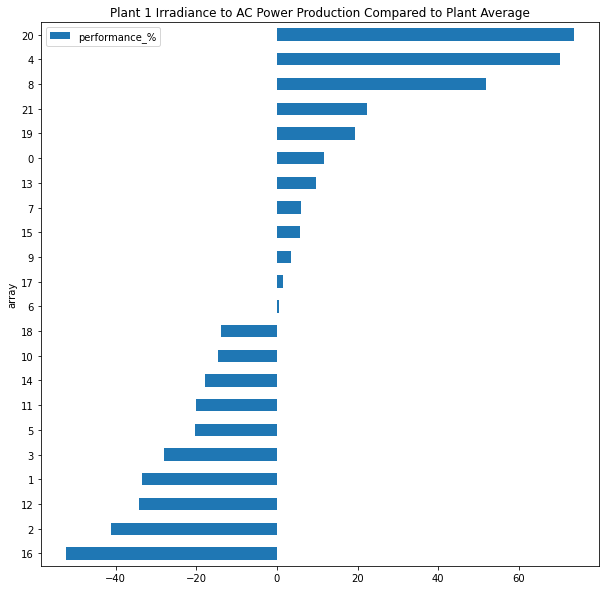

In [52]:
performance_to_mean_irrad(irrad_df, 'irrad_yield', '1', 'Plant 1 Irradiance to AC Power Production Compared to Plant Average')
performance_to_mean_irrad(irrad_df, 'irrad_yield', '2', 'Plant 1 Irradiance to AC Power Production Compared to Plant Average')

# Poor irradiation may suggest cleaning needs.
# Poor performance may suggest maintenance needs.

# Reference:

https://www.kaggle.com/code/tantable/solar-power-generation-data-work-in-progress

https://www.kaggle.com/code/virosky/how-to-manage-a-solar-power-plant